In [7]:
#!pip install tqdm
from typing import Callable
from collections import namedtuple
from copy import deepcopy as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

In [8]:
class NNLinear:
    wb: np.ndarray
    inputs: np.ndarray
    optimizer: str
    grad_pre: np.ndarray = None
    H: np.ndarray = None
    wb_pre: np.ndarray = None

    def __init__(self, in_len, out_len, optimizer, perceptron):
        self.wb = np.random.rand(in_len+1, out_len)-0.5
        self.optimizer = optimizer
        self.perceptron = perceptron

    def __repr__(self):
        return f'NNLinear({self.wb.shape})'

    def __eq__(self, o):
        return id(self) == id(o)

    def forward(self, inputs: np.ndarray):
        '''
        inputs - вектор-строка длинны in_len
        '''
        # print(f'    -> forward in {self}')
        self.inputs = np.append(inputs, [1])
        return self.inputs @ self.wb

    def simple_forward(self, inputs: np.ndarray):
        '''
        inputs - вектор-строка длинны in_len
        '''
        return np.append(inputs, [1]) @ self.wb

    def simple_backward(self, grad):
        return (grad @ self.wb.T)[:-1]

    def backward(self, grad):
        # print(f'BACKWARD IN {self}')
        # вычисляем градиент, который прокинем
        # до шага оптимизатора
        grad_to_ret = (grad @ self.wb.T)[:-1]  # отрезаем градиент для bias
        # считаем градиент относительно параметров слоя
        grad_wb = np.reshape(self.inputs, (-1, 1)) @ np.reshape(grad, (1, -1))
        if np.linalg.norm(grad_wb) != 0:
            grad_wb = grad_wb/np.linalg.norm(grad_wb)

        if np.linalg.norm(grad_to_ret) != 0:
            grad_to_ret = grad_to_ret/np.linalg.norm(grad_to_ret)

        if self.optimizer == 'GD':
            d = grad_wb
        elif self.optimizer == 'FR':
            # первый шаг
            if self.grad_pre is None:
                self.grad_pre = grad_wb
                b = 0
            # обычный шаг
            else:
                grad = grad_wb.flatten()
                grad_pre = self.grad_pre.flatten()
                if np.linalg.norm(grad_pre) > 0.00001:
                    b = (np.sum(grad*grad)/np.sum(grad_pre*grad_pre))**2
                else:
                    b = 1
                b = max(min(b, 1), 0)
            # считаем направление смещения
            d = (grad_wb + b*self.grad_pre)
            # запоминаем "старый" градиент
            self.grad_pre = grad_wb
        elif self.optimizer == 'BFGS':
            # инициализация
            if self.H is None:
                self.H = np.identity(len(grad_wb))
                self.grad_pre = np.zeros(grad_wb.shape)
                self.wb_pre = np.zeros(self.wb.shape)

            # считаем направление смещения
            d = (self.H @ grad_wb)

            # обновляем гессиан
            y = grad_wb - self.grad_pre
            s = self.wb - self.wb_pre

            W1 = np.eye(len(grad_wb)) - s @ y.T
            self.H = W1 @ self.H @ W1.T

            # запоминаем "старые" значения
            self.grad_pre = grad_wb
            self.wb_pre = self.wb
        else:
            raise RuntimeError('unknown optimizing method')

        # print('start linear search')
        if np.linalg.norm(d) > 0.001:
            d = LR * d / np.linalg.norm(d)
        

        # self.wb -= d
        # return grad_to_ret

        def calc_special():
            return self.perceptron.calc_for_special_layer(self, self.inputs[:-1])

        old_res_val = calc_special()
        # print(f'    {old_res_val}')
        self.wb -= d
        new_res_val = calc_special()
        # print(f'    {new_res_val}')
        if new_res_val < old_res_val and abs(new_res_val - old_res_val) > 0.0001:
            while new_res_val < old_res_val and abs(new_res_val - old_res_val) > 0.0001:
                self.wb -= d
                old_res_val = new_res_val
                new_res_val = calc_special()
                # print(f'    {new_res_val}')
            self.wb += d

        # прокидываем градиент дальше
        return grad_to_ret
        # return self.perceptron.fit_special_layer_get_my_grad(self, self.inputs[:-1])

###### функции

In [9]:
relu = np.vectorize(lambda x: x if x > 0 else 0)
der_relu = np.vectorize(lambda x: 1 if x > 0 else 0)


class NNRelu:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return relu(inputs)

    def backward(self, grad):
        res = grad * der_relu(self.inputs)
        return res


def sigmoid(x): return 1/(1+np.exp(-x))
def der_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))


class NNSigmoid:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return sigmoid(inputs)

    def backward(self, grad):
        res = grad * der_sigmoid(self.inputs)
        return res

In [10]:
import warnings
warnings.filterwarnings("error")


def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x)/(np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


class NNSoftmax:
    inputs: np.ndarray

    def forward(self, inputs):
        self.inputs = inputs
        return softmax(inputs)

    def backward(self, grad):
        res = grad * softmax(self.inputs)*(1-softmax(self.inputs))
        return res

## Loss functions

In [11]:
LossFunc = namedtuple('LossFunc', ['f', 'df', 'name'])

In [12]:
def mse(x, y): return sum((x-y)**2)/len(x)


def der_mse(x, y):
    res = (x-y)*2/len(x)*-1
    return res / np.sum(np.abs(res))


MSE = LossFunc(mse, der_mse, 'MSE LOSS')

In [13]:
def cross_entropy(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    return -np.mean(target * np.log(pred))


def der_cross_entropy(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    res = pred - target
    return res / np.linalg.norm(res)


CrossEntropy = LossFunc(cross_entropy, der_cross_entropy, 'Cross Entropy LOSS')

In [14]:
def kl(target, pred):
    pred = np.clip(pred, 1e-10, 1 - 1e-10)
    target = np.clip(pred, 1e-10, 1 - 1e-10)
    res = np.mean(target * np.log(target/pred))
    return res


def der_kl(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    res = pred - target
    return res / np.linalg.norm(res)


KLDiv = LossFunc(kl, der_kl, 'Kullback–Leibler Divergence LOSS')

In [15]:
GD = 'GD'
FR = 'FR'
BFGS = 'BFGS'

###### модель

In [16]:
class Perceptron:
    layers: list
    loss: LossFunc
    last_target: np.ndarray

    def __init__(self, sizes: list[int], loss, optimizer):
        self.layers = [
            x for i, o in zip(sizes, sizes[1:]+[10]) for x in [NNLinear(i, o, optimizer, self), NNSigmoid()]
        ] + [NNSoftmax()]
        self.loss = loss

    def forward(self, inputs):
        res = inputs
        for layer in self.layers:
            res = layer.forward(res)
        return res

    def backward(self, target, pred):
        grad_by_last_layer_outs = self.loss.df(target, pred)
        grad = grad_by_last_layer_outs
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, x, y):
        self.last_target = y
        pred = self.forward(x)
        self.backward(y, pred)
        return np.argmax(pred)

    def predict(self, x, y):
        pred = self.forward(x)
        return np.argmax(pred)

    def calc_for_special_layer(self, layer: NNLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(
                layer) != NNLinear else layer.simple_forward(res)
        return self.loss.f(self.last_target, res)

    def fit_special_layer_get_my_grad(self, layer: NNLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(
                layer) != NNLinear else layer.simple_forward(res)
        grad_by_last_layer_outs = self.loss.df(self.last_target, res)
        grad = grad_by_last_layer_outs
        for layer in self.layers[index:][::-1]:
            grad = layer.backward(grad) if type(
                layer) != NNLinear else layer.simple_backward(res)
        return grad

###### данные

In [17]:
ds = datasets.MNIST(
    root='data',
    train=True,
    download=True,

    transform=lambda img: np.array(np.asarray(img).flatten())/256,
    target_transform=lambda x: np.array(
        [1 if i == x else 0 for i in range(10)])
)
ds1 = Subset(ds, range(0, 1000))
dl1 = DataLoader(ds1, shuffle=True, batch_size=None)

ds2 = Subset(ds, range(1000, 1000+100))
dl2 = DataLoader(ds2, shuffle=True, batch_size=None)

##### Тренируем

###### функции тренировки

In [18]:
ACC = []

def train_epoch(model):
    results = 0
    for X, y in dl1:
        X, y = np.array(X), np.array(y)
        pred = model.fit(X, y)
    for X, y in dl2:
        X, y = np.array(X), np.array(y)
        pred = model.predict(X, y)
        results += (np.argmax(y) == pred)
    return results/len(dl2)


def train_many_epochs(model, N):
    global ACC
    accuracy = []
    for _ in tqdm(range(N)):
        a = train_epoch(model)
        print(a)
        accuracy.append(a)
        ACC = accuracy
    return accuracy

###### тренировка

In [19]:
def demo(optim, loss, lr, epochs):
    global LR
    LR = lr
    p = Perceptron(
        [784] + [64] + [10],
        optim,
        loss
    )
    accuracy = train_many_epochs(p, epochs)
    plt.plot(np.arange(len(accuracy)), accuracy)
    return accuracy

## Gradient Descent

In [ ]:
mse_res = demo(MSE, GD, 0.009, 60)
ce_res = demo(CrossEntropy, GD, 0.009, 60)
kld_res = demo(KLDiv, GD, 0.009, 60)

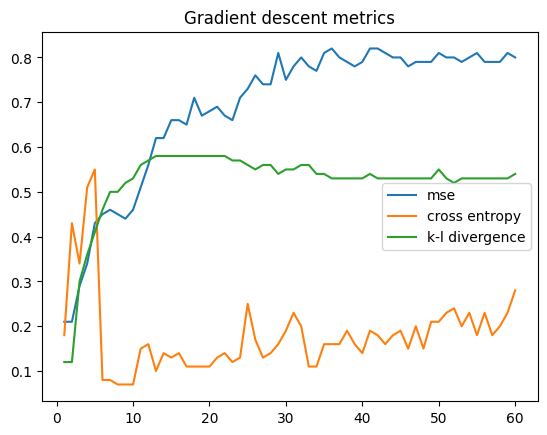

In [21]:
plt.plot(range(1, 61), mse_res, label='mse')
plt.plot(range(1, 61), ce_res, label='cross entropy')
plt.plot(range(1, 61), kld_res, label='k-l divergence')
plt.legend()
plt.title('Gradient descent metrics')
plt.show()

## FR
### Флетчера-Ривза 

In [ ]:
fr_ce_res = demo(CrossEntropy, FR, 0.0085, 40)
fr_mse_res = demo(MSE, FR, 0.0085, 40)
fr_kl_res = demo(KLDiv, FR, 0.0085, 40)

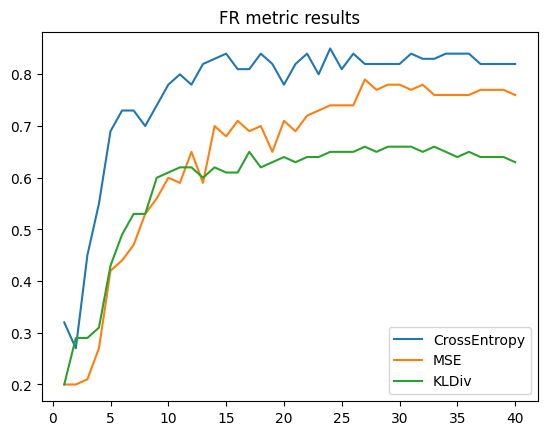

In [23]:
plt.plot(range(1, 41), fr_ce_res, label='CrossEntropy')
plt.plot(range(1, 41), fr_mse_res, label='MSE')
plt.plot(range(1, 41), fr_kl_res, label='KLDiv')
plt.legend()
plt.title('FR metric results')
plt.show()

## BFGS
### Квазиньютоновский метод 

In [24]:
bfgs_ce_res = demo(CrossEntropy, BFGS, 0.001, 40)
bfgs_mse_res = demo(MSE, BFGS, 0.001, 40)
bfgs_kl_res = demo(KLDiv, BFGS, 0.001, 40)

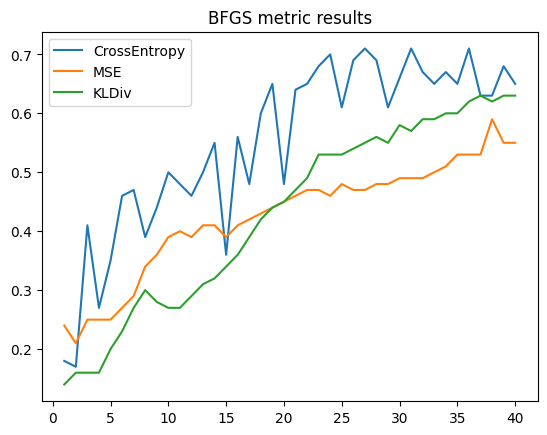

In [24]:
plt.plot(range(1, 41), bfgs_ce_res, label='CrossEntropy')
plt.plot(range(1, 41), bfgs_mse_res, label='MSE')
plt.plot(range(1, 41), bfgs_kl_res, label='KLDiv')
plt.legend()
plt.title('BFGS metric results')
plt.show()